In [1]:
import sys
sys.path.append("../src/data") 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from feature_builder import FeatureBuilder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.metrics import accuracy_score, classification_report, log_loss, confusion_matrix

In [3]:
# Split the data into training, validation, and test sets if not already done
from generate_data_splits import generate_splits
generate_splits()

(1149, 246, 249)

In [4]:
# Load and preprocess the data
train_data = FeatureBuilder(file_path="../data/raw_splits/train_data.csv", normalize=False, exclude_columns=[]).build_features()
val_data = FeatureBuilder(file_path="../data/raw_splits/val_data.csv", normalize=False, exclude_columns=[]).build_features()
test_data = FeatureBuilder(file_path="../data/raw_splits/test_data.csv", normalize=False, exclude_columns=[]).build_features()

# Separate features (X) and labels (y)
X_train = train_data.drop(["id", "label"], axis=1)
y_train = train_data["label"]
X_val = val_data.drop(["id", "label"], axis=1)
y_val = val_data["label"]
X_test = test_data.drop(["id", "label"], axis=1)
y_test = test_data["label"]

d:\Personal Projects\311-ML-Food-Prediction\notebooks\../src/data\feature_builder.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.df = self.df.applymap(lambda x: x.lower())
d:\Personal Projects\311-ML-Food-Prediction\notebooks\../src/data\feature_builder.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.df = self.df.applymap(lambda x: x.lower())
d:\Personal Projects\311-ML-Food-Prediction\notebooks\../src/data\feature_builder.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.df = self.df.applymap(lambda x: x.lower())


In [5]:
print(X_train.columns)

Index(['q1_processed', 'q2_ingredient_count', 'q2_pizza_prob',
       'q2_shawarma_prob', 'q2_sushi_prob', 'q3_week_day_lunch',
       'q3_week_day_dinner', 'q3_weekend_lunch', 'q3_weekend_dinner',
       'q3_at_a_party', 'q3_late_night_snack', 'q4_processed', 'q5_pizza_prob',
       'q5_shawarma_prob', 'q5_sushi_prob', 'q6_pizza_prob',
       'q6_shawarma_prob', 'q6_sushi_prob', 'q7_parents', 'q7_siblings',
       'q7_friends', 'q7_teachers', 'q7_strangers', 'q8_processed',
       'q1_times_q2', 'q1_times_q4', 'q4_divided_by_q1', 'q2_times_q4',
       'q2_divided_by_q4', 'q4_divided_by_q2', 'q8_divided_by_q2',
       'q8_divided_by_q4'],
      dtype='object')


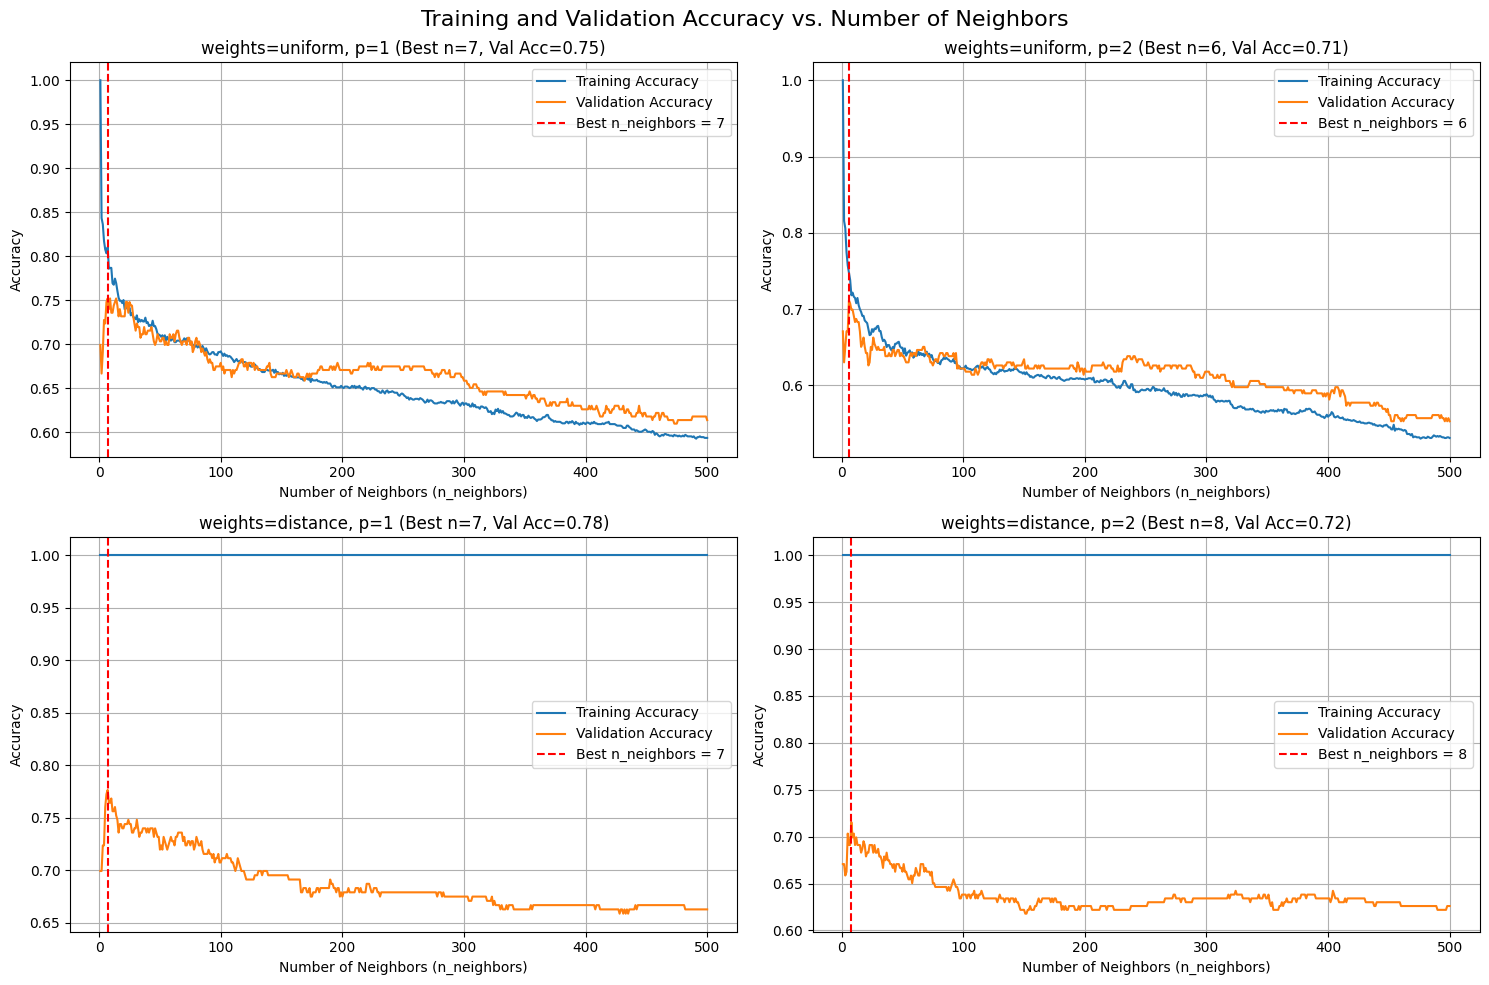

In [6]:
# Approach 1: Manual Search
# Train the model on the entire training set (X_train, y_train).
# Evaluate the model on the validation set (X_val, y_val).
# The validation accuracy is computed on a single validation set, which can be sensitive to the specific split of the data.

# Define the parameter combinations
weights_options = ["uniform", "distance"]
p_options = [1, 2]  # 1: Manhattan, 2: Euclidean
neighbors_range = list(range(1, 501))  # Range of n_neighbors to test

# Create a grid of plots
fig, axes = plt.subplots(len(weights_options), len(p_options), figsize=(15, 10))
fig.suptitle("Training and Validation Accuracy vs. Number of Neighbors", fontsize=16)

# Loop through each combination of weights and p
for i, weights in enumerate(weights_options):
    for j, p in enumerate(p_options):
        # Lists to store accuracy values
        train_accuracy = []
        val_accuracy = []

        # Test different values of n_neighbors
        for n in neighbors_range:
            # Initialize the KNN model
            knn = KNeighborsClassifier(n_neighbors=n, weights=weights, p=p)
            
            # Train the model
            knn.fit(X_train, y_train)
            
            # Record training accuracy
            train_accuracy.append(knn.score(X_train, y_train))
            
            # Record validation accuracy
            val_accuracy.append(knn.score(X_val, y_val))

        # Find the best n_neighbors
        # best_n_index = len(val_accuracy) - np.argmax(val_accuracy[::-1]) - 1 # Find the index of the last occurrence of the maximum value
        best_n_index = np.argmax(val_accuracy)
        best_n = neighbors_range[best_n_index]
        best_val_accuracy = val_accuracy[best_n_index]

        # Plot the results
        ax = axes[i, j]
        ax.plot(neighbors_range, train_accuracy, label="Training Accuracy")
        ax.plot(neighbors_range, val_accuracy, label="Validation Accuracy")
        ax.axvline(x=best_n, color="red", linestyle="--", label=f"Best n_neighbors = {best_n}")
        ax.set_xlabel("Number of Neighbors (n_neighbors)")
        ax.set_ylabel("Accuracy")
        ax.set_title(f"weights={weights}, p={p} (Best n={best_n}, Val Acc={best_val_accuracy:.2f})")
        ax.legend()
        ax.grid()

plt.tight_layout()
# plt.savefig("visualizations/knn_accuracy_norm_on.png")
plt.show()

In [7]:
# Approach 2: Automatic Search
# GridSearchCV uses cross-validation (We will use group-based cross-validation with GridSearchCV to ensures that each fold contains unique ids)
# The training set (X_train, y_train) is split into k folds.
# For each combination of hyperparameters:
#   The model is trained on k-1 folds and validated on the remaining fold.
#   This process is repeated k times, and the average validation score is computed.
# The validation accuracy reported by GridSearchCV is the average accuracy across all folds, which is more robust and less sensitive to the specific split of the data.

# Best Parameters: {'n_neighbors': 29, 'p': 1, 'weights': 'distance'}
# Best Validation Accuracy: 0.9362007168458781
# Test Accuracy: 0.9076305220883534

# Define the parameter grid
param_grid = {
    "n_neighbors": list(range(1, 501)),
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}

# Initialize the KNN model
knn = KNeighborsClassifier()

# Define the GroupKFold object
group_kfold = GroupKFold(n_splits=5) # Data is divided into 5 folds, the model is trained and validated 5 times, each time using a different fold as the validation set and the remaining folds as the training set

# Perform grid search with GroupKFold
grid_search = GridSearchCV(knn, param_grid, cv=group_kfold, scoring="accuracy", n_jobs=-1)

# Combine training and validation data
X_train_final = pd.concat([X_train, X_val])
y_train_final = pd.concat([y_train, y_val])
groups_final = pd.concat([train_data["id"], val_data["id"]])

# Fit the grid search with groups
grid_search.fit(X_train_final, y_train_final, groups=groups_final)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Validation Accuracy:", grid_search.best_score_)

# Evaluate best model on test set
test_predictions = grid_search.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, test_predictions))
print("Test Classification Report:\n", classification_report(y_test, test_predictions))

Best Parameters: {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Best Validation Accuracy: 0.7505376344086022
Test Accuracy: 0.6746987951807228
Test Classification Report:
               precision    recall  f1-score   support

       pizza       0.71      0.63      0.67        83
    shawarma       0.71      0.65      0.68        83
       sushi       0.62      0.75      0.68        83

    accuracy                           0.67       249
   macro avg       0.68      0.67      0.67       249
weighted avg       0.68      0.67      0.67       249



In [8]:
# Initialize Best KNN model
best_knn = KNeighborsClassifier(n_neighbors=29, p=1, weights="distance")

# Train the model
best_knn.fit(X_train, y_train)

# Record test accuracy
test_predictions = best_knn.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, test_predictions))
print("Test Classification Report:\n", classification_report(y_test, test_predictions))
print("Log Loss:", log_loss(y_test, best_knn.predict_proba(X_test)))

Test Accuracy: 0.6506024096385542
Test Classification Report:
               precision    recall  f1-score   support

       pizza       0.68      0.58      0.62        83
    shawarma       0.65      0.69      0.67        83
       sushi       0.63      0.69      0.66        83

    accuracy                           0.65       249
   macro avg       0.65      0.65      0.65       249
weighted avg       0.65      0.65      0.65       249

Log Loss: 0.8718690919162312


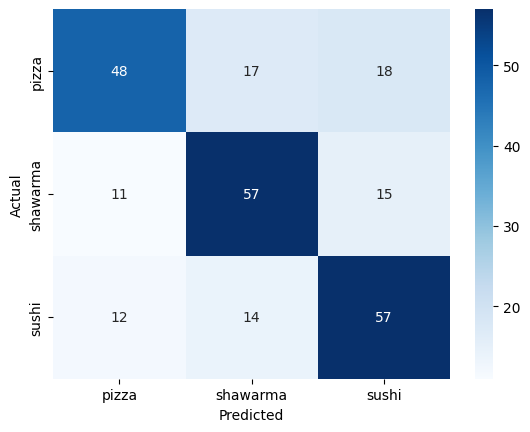

In [9]:
class_names = ["pizza", "shawarma", "sushi"]  
cm = confusion_matrix(y_test, test_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.savefig("visualizations/knn_confusion_mat.png")
plt.show()

Notes / Observations / Thoughts:
- Best Parameters are from GridSearchCV because it is more robust as it it averaged over multiple folds. Compared to manual search we see that for this specific validation set highest validation accuracy achieved with n=4,6,21,40,42,..., but the test accuracy increases and starts to decrease.
    - Smaller values of `n_neighbors` (e.g., 4, 6) may lead to overfitting, as the model becomes too sensitive to local noise.
    - Larger values of `n_neighbors` (e.g., 21, 40, 42) may lead to underfitting, as the model becomes too simplistic.
    - Optimal Choice: `n_neighbors=13` strikes a balance between overfitting and underfitting, as evidenced by its strong performance on both validation and test sets.
- Manhattan distance seems to be performing better than Euclidean distance (Euclidean distance is affected more in higher dimensions).
- k-NN is a non-parametric and universal function approximator, meaning it can model complex relationships without assuming a specific form for the underlying data distribution.
   - **Advantages**:
     - No assumptions about the data distribution.
     - Simple to implement and interpret.
   - **Limitations**:
     - Have to store training data and use it during inference which is slow.
     - **Curse of Dimensionality**: Performance degrades as the number of features increases, because distances become less meaningful in high-dimensional spaces. Moreover, distance computation also get more expensive.
- Normalization helped a lot.